In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import sys
import pyfolio as pf

In [45]:
sys.path.insert(0, r'../src')
from function_cache import *

In [46]:
# spread price continuous data
T_spread_price = pd.read_csv(
    "../data/processed/spread_price/T_spread_price.csv",
    index_col="Trading_Day",
    parse_dates=True,
)
TF_spread_price = pd.read_csv(
    "../data/processed/spread_price/TF_spread_price.csv",
    index_col="Trading_Day",
    parse_dates=True,
)

In [47]:
# start and end date of roll period
T_roll_period = pd.read_csv(
    "../data/processed/roll_period/T_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")
TF_roll_period = pd.read_csv(
    "../data/processed/roll_period/TF_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")

In [48]:
# list of contract by time sequence
T_contract_list = list(T_roll_period.index)
TF_contract_list = list(TF_roll_period.index)

In [49]:
def find_next_contract(contract, contract_list):

    contract_sr = pd.Series(index=contract_list)

    if contract in contract_list:
        return contract_sr[contract:].index[1]
    else:
        return None

In [50]:
T_feature = pd.read_csv('../data/processed/candidate_features/T_features.csv', index_col=0)
TF_feature = pd.read_csv('../data/processed/candidate_features/TF_features.csv', index_col=0)

In [51]:
feature_name = '-1d_corr_act_volume_def_volume'

## T

### Estimated

In [52]:
T_spread_return = T_spread_price.copy()
T_spread_return['spread_price_ret'] = T_spread_return['spread_price'].diff() / 200
T_spread_return = T_spread_return.dropna()
T_spread_return['spread_return'] = None

for active_contract in T_roll_period.shift(-1).dropna().index:
    
    deferred_contract = find_next_contract(active_contract, T_contract_list)
    signal = np.sign(T_feature.loc[active_contract, feature_name])
    
    start_date = T_roll_period.loc[deferred_contract, 'start']
    day_after_start = T_spread_price[start_date:].index[1]
    end_date = T_roll_period.loc[deferred_contract, 'end']
    
    ret = T_spread_return.loc[day_after_start:end_date, 'spread_price_ret'] * signal
    T_spread_return.loc[day_after_start:end_date, 'spread_return'] = ret


Start date,2015-03-23
End date,2019-07-30
Total months,50
,Backtest
Annual return,0.1%
Cumulative returns,0.5%
Annual volatility,0.3%
Sharpe ratio,0.35
Calmar ratio,0.12
Stability,0.18
Max drawdown,-0.9%


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.92,2017-02-06,2019-05-29,NaT,NaN
1,0.34,2016-04-25,2016-08-05,2016-12-19,171
2,0.23,2017-01-04,2017-01-10,2017-02-03,23
3,0.15,2016-12-19,2016-12-21,2017-01-03,12
4,0.10,2016-02-04,2016-02-15,2016-02-19,12


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


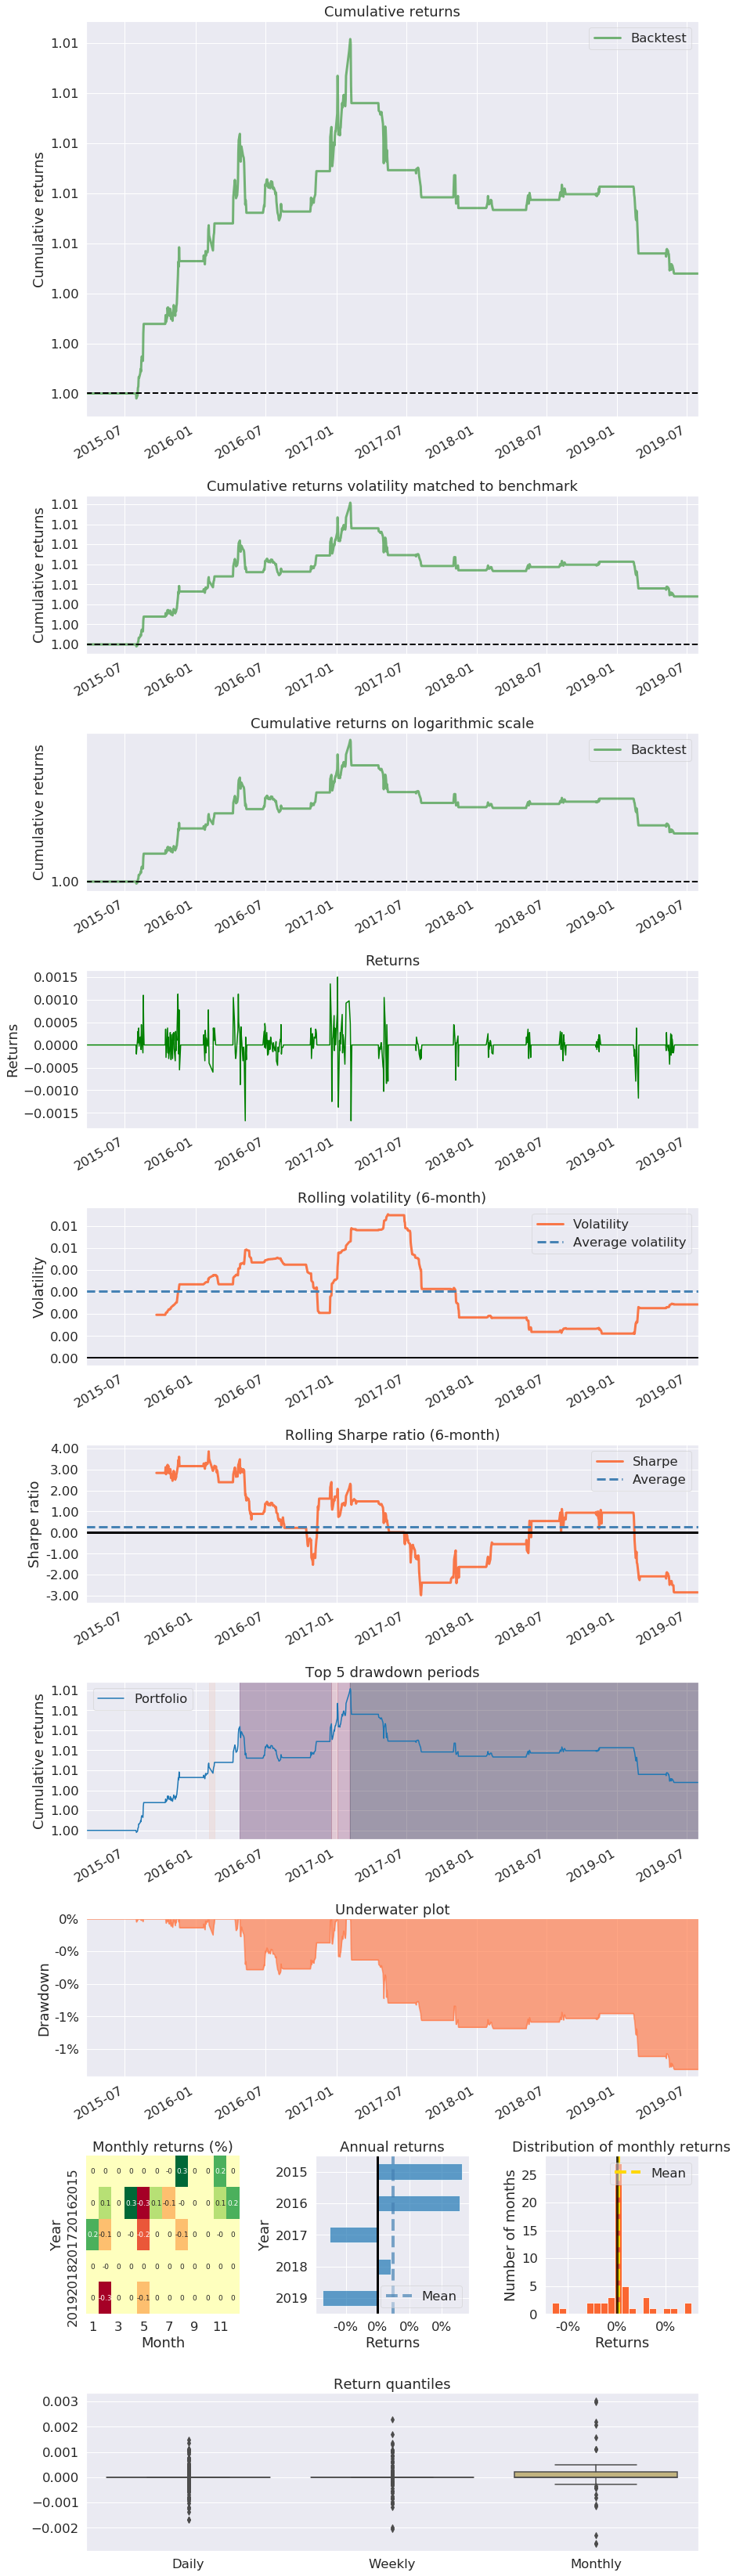

In [53]:
pf.create_returns_tear_sheet(T_spread_return['spread_return'].fillna(0))

0.703 0.005 0.006 0.009 1.425 0.133 0.695


(0.004553896307107452, 0.006481702177806697, 0.7025772215668843)

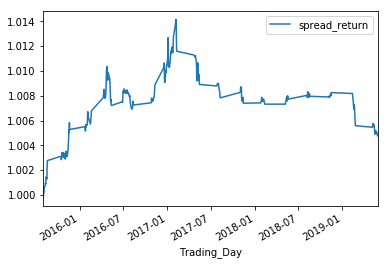

In [54]:
grading_(T_spread_return['spread_return'].dropna().astype(float))

### Accurate

In [55]:
T_spread_return_acc = T_roll_period.shift(-1).dropna().copy()
T_spread_return_acc['spread_return'] = None

for active_contract in T_spread_return_acc.index:
    

    signal = -np.sign(T_feature.loc[active_contract, feature_name])
    
    start_date = T_spread_return_acc.loc[active_contract, 'start']
    end_date = T_spread_return_acc.loc[active_contract, 'end']
    
    active_change = T_spread_price.loc[end_date, 'active_contract_price'] - T_spread_price.loc[start_date, 'active_contract_price']
    deferred_change = T_spread_price.loc[start_date, 'deferred_contract_price'] - T_spread_price.loc[end_date, 'deferred_contract_price']
    ret = signal * (active_change + deferred_change)/ (T_spread_price.loc[start_date, 'active_contract_price'] + T_spread_price.loc[start_date, 'deferred_contract_price'])
    T_spread_return_acc.loc[active_contract, 'spread_return'] = ret


In [56]:
T_spread_return_acc

,start,end,spread_return
contract,,,
T1509,2015-07-30,2015-08-19,-0.00288432
T1512,2015-10-14,2015-11-20,-0.0025312
T1603,2016-01-21,2016-02-19,-0.00149775
T1606,2016-04-07,2016-05-12,-0.000429239
T1609,2016-06-24,2016-08-16,-5.002e-05
T1612,2016-10-25,2016-11-10,-0.00158083
T1703,2016-12-15,2017-02-09,-0.00286853
T1706,2017-04-20,2017-05-15,0.00276683
T1709,2017-07-26,2017-08-10,0.00113319


## TF

In [57]:
TF_spread_return = TF_spread_price.copy()
TF_spread_return['spread_price_ret'] = TF_spread_return['spread_price'].diff() / 200
TF_spread_return = TF_spread_return.dropna()
TF_spread_return['spread_return'] = None

for active_contract in TF_roll_period.shift(-1).dropna().index:
    
    deferred_contract = find_next_contract(active_contract, TF_contract_list)
    signal = np.sign(TF_feature.loc[active_contract, feature_name])
    
    start_date = TF_roll_period.loc[deferred_contract, 'start']
    day_after_start = TF_spread_price[start_date:].index[1]
    end_date = TF_roll_period.loc[deferred_contract, 'end']
    
    ret = TF_spread_return.loc[day_after_start:end_date, 'spread_price_ret'] * signal
    TF_spread_return.loc[day_after_start:end_date, 'spread_return'] = ret


Start date,2013-09-09
End date,2019-07-30
Total months,68
,Backtest
Annual return,0.0%
Cumulative returns,0.2%
Annual volatility,0.2%
Sharpe ratio,0.11
Calmar ratio,0.06
Stability,0.50
Max drawdown,-0.4%


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.45,2013-11-19,2015-07-08,2016-12-30,814
1,0.32,2017-05-08,2018-11-27,NaT,NaN
2,0.10,2017-01-05,2017-01-12,2017-01-26,16
3,0.04,2013-11-12,2013-11-14,2013-11-18,5
4,0.00,2013-09-09,2013-09-09,2013-09-09,1


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


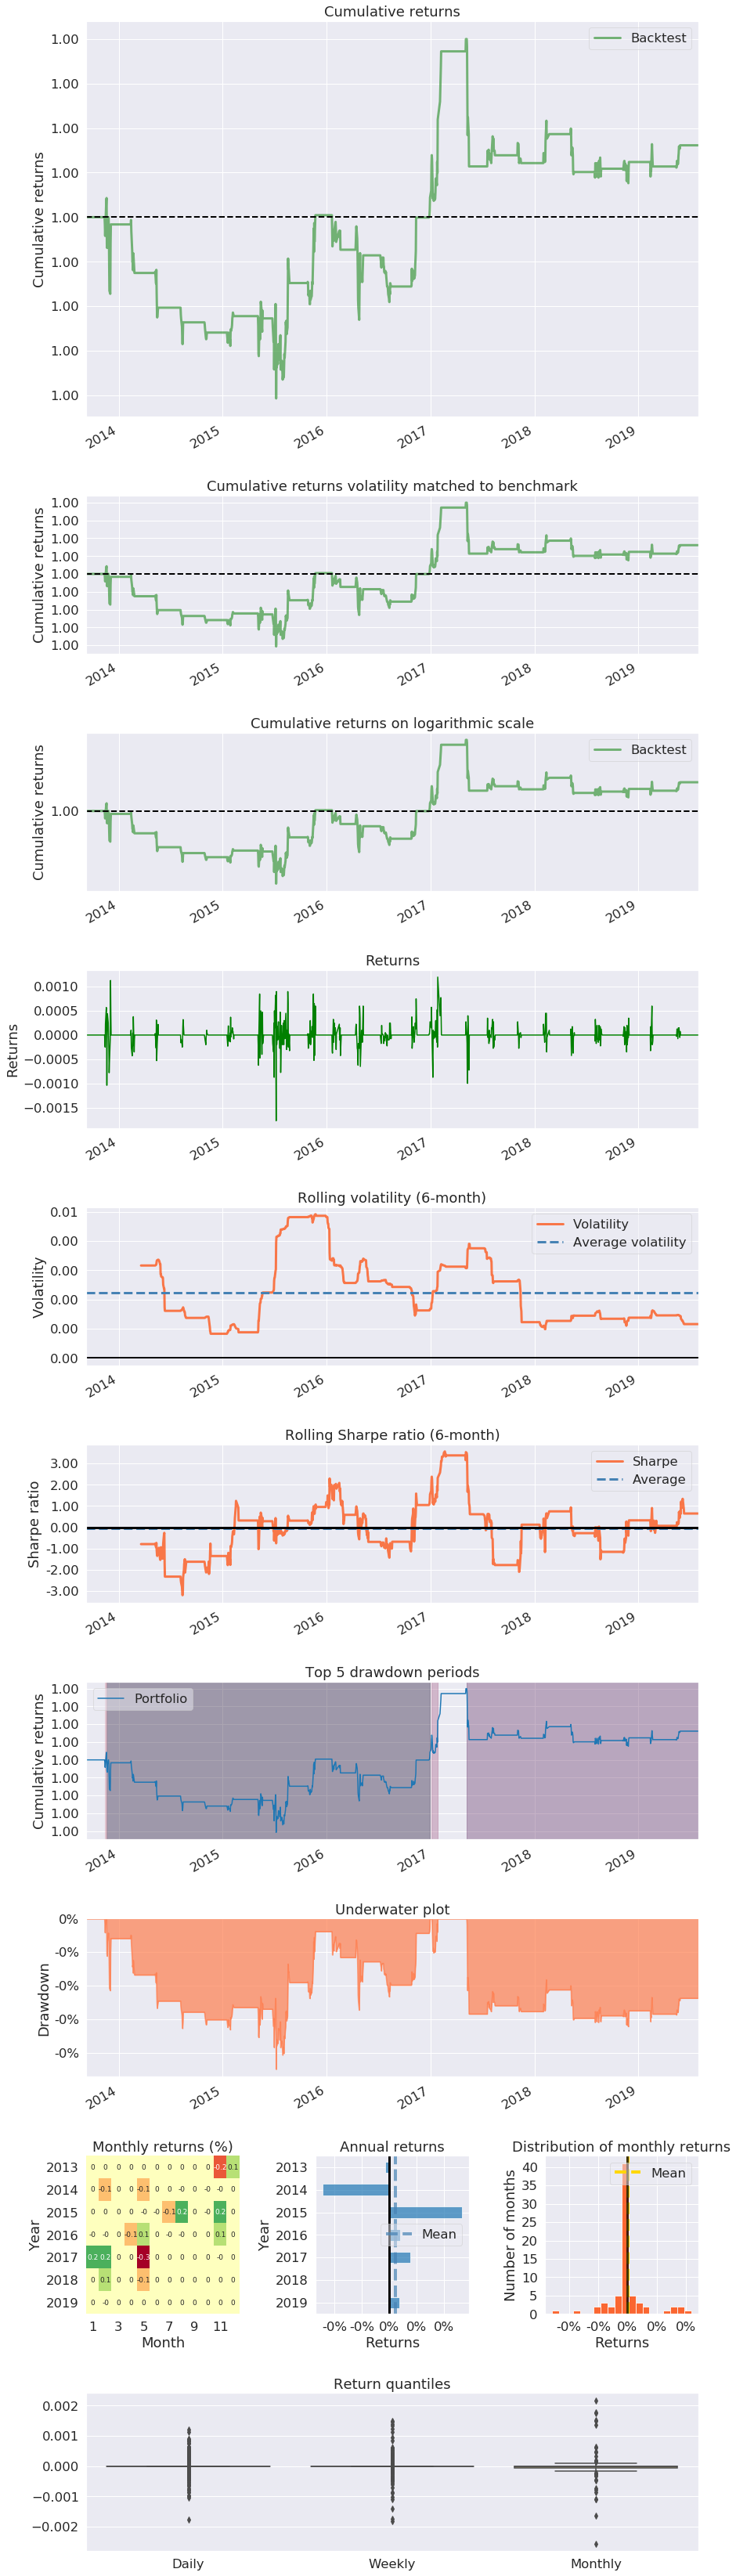

In [58]:
pf.create_returns_tear_sheet(TF_spread_return['spread_return'].fillna(0))

0.232 0.001 0.005 0.004 0.882 0.044 0.232


(0.0011852822125477669, 0.0051000193761347595, 0.2324073939981925)

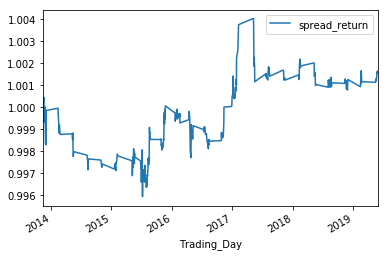

In [59]:
grading_(TF_spread_return['spread_return'].dropna().astype(float))

### Accurate

In [60]:
TF_spread_return_acc = TF_roll_period.shift(-1).dropna().copy()
TF_spread_return_acc['spread_return'] = None

for active_contract in TF_spread_return_acc.index:
    

    signal = -np.sign(TF_feature.loc[active_contract, feature_name])
    
    start_date = TF_spread_return_acc.loc[active_contract, 'start']
    end_date = TF_spread_return_acc.loc[active_contract, 'end']
    
    active_change = TF_spread_price.loc[end_date, 'active_contract_price'] - TF_spread_price.loc[start_date, 'active_contract_price']
    deferred_change = TF_spread_price.loc[start_date, 'deferred_contract_price'] - TF_spread_price.loc[end_date, 'deferred_contract_price']
    ret = signal * (active_change + deferred_change)/ (TF_spread_price.loc[start_date, 'active_contract_price'] + TF_spread_price.loc[start_date, 'deferred_contract_price'])
    TF_spread_return_acc.loc[active_contract, 'spread_return'] = ret

TF_spread_return_acc

,start,end,spread_return
contract,,,
TF1312,2013-11-12,2013-12-04,0.000173312
TF1403,2014-02-12,2014-02-25,0.00117642
TF1406,2014-05-08,2014-05-19,0.000836596
TF1409,2014-08-06,2014-08-15,0.000353774
TF1412,2014-10-29,2014-11-07,0.000239561
TF1503,2015-01-16,2015-02-09,-0.000378706
TF1506,2015-05-05,2015-05-22,5.08686e-05
TF1509,2015-06-25,2015-08-25,-0.000825934
TF1512,2015-10-23,2015-11-23,-0.00152443
